In [54]:
import time
from feldmansecretsharing import FeldmanVerifiableSecretSharing
from asmuthbloomsharing import AsmuthBloom
from blakleysecretsharing import BlakleySecretSharing
from pedersenscheme import PedersenSecretSharing
from shamirsecretsharing import ShamirSecretSharing

In [55]:
import matplotlib.pyplot as plt
import numpy as np

In [56]:
secret = 123456789
threshold = 5
num_shares = 10

In [57]:
def benchmark(name, split_func, verify_func, reconstruct_func, num_iterations=1000):
    print(f"\nBenchmarking {name}...")

    # Store the times for each subsection over all iterations
    split_times = []
    verify_times = []
    reconstruct_times = []

    for _ in range(num_iterations):
        start_total = time.perf_counter()

        # Split phase
        start = time.perf_counter()
        shares, metadata = split_func()
        end = time.perf_counter()
        split_times.append(end - start)

        # Verification phase
        if verify_func is not None:
            start = time.perf_counter()
            for share in shares:
                verify_func(share, metadata)
            end = time.perf_counter()
            verify_times.append(end - start)
        else:
            verify_times.append(0)  # No verification phase if function is None

        # Reconstruction phase
        start = time.perf_counter()
        if metadata is not None:
            reconstruct_func((shares, metadata))
        else:
            reconstruct_func(shares)
        end = time.perf_counter()
        reconstruct_times.append(end - start)

        end_total = time.perf_counter()

    # Calculate average times
    avg_split_time = np.mean(split_times)
    avg_verify_time = np.mean(verify_times)
    avg_reconstruct_time = np.mean(reconstruct_times)

    print(f"Average Split time: {avg_split_time:.6f} seconds")
    print(f"Average Verification time: {avg_verify_time:.6f} seconds")
    print(f"Average Reconstruction time: {avg_reconstruct_time:.6f} seconds")

    return avg_split_time, avg_verify_time, avg_reconstruct_time

In [58]:

### Feldman
feldman = FeldmanVerifiableSecretSharing(threshold=threshold, num_shares=num_shares)

def feldman_split():
    shares, commitments = feldman.split(secret)
    return shares, commitments

def feldman_verify(share, commitments):
    x, y = share
    feldman.verify_share(x, y, commitments)

def feldman_reconstruct(input_val):
    # Accept either a list of shares or a tuple (shares, metadata)
    if isinstance(input_val, tuple):
        shares, _ = input_val
    else:
        shares = input_val
    return feldman.reconstruct(shares[:threshold])


In [59]:
### Asmuth-Bloom
def ab_split():
    ab = AsmuthBloom(n_holders=num_shares, min_holder=threshold, secret=secret, verbose=False)
    return ab.get_holders(), ab

def ab_reconstruct(holders_and_ab):
    holders, ab = holders_and_ab
    # Inject holders into ab to make sure solve() uses them
    ab.holders = holders
    return ab.solve()

In [60]:
### Blakley
blakley = BlakleySecretSharing(threshold=threshold, num_shares=num_shares)

def blakley_split():
    shares = blakley.split(secret)
    return shares, None

def blakley_reconstruct(shares):
    return blakley.reconstruct(shares[:threshold])

In [61]:
### Pedersen
pedersen = PedersenSecretSharing(threshold=threshold, num_shares=num_shares)

def pedersen_split():
    shares, commitments = pedersen.split(secret)
    return shares, commitments

def pedersen_verify(share, commitments):
    x, s, r = share
    return pedersen.verify_share(x, s, r, commitments)

def pedersen_reconstruct(shares_and_commitments):
    shares, _ = shares_and_commitments
    return pedersen.reconstruct([(x, s) for x, s, r in shares[:threshold]])

In [62]:
### Shamir
sss = ShamirSecretSharing(threshold=threshold, num_shares=num_shares, bit_length=256)

def shamir_split():
    shares = sss.split(secret)
    # Add a dummy third element 'r' to simulate Pedersen's (x, s, r)
    shares_with_r = [(x, y, 0) for (x, y) in shares]
    return shares_with_r, None

def shamir_reconstruct(shares_with_r):
    # Simulate Pedersen's unpacking overhead
    sliced = shares_with_r[:threshold]
    just_shares = [(x, y) for (x, y, r) in sliced]
    return sss.reconstruct(just_shares)

In [63]:
feldman_split_time, feldman_verify_time, feldman_reconstruct_time = benchmark("Feldman", feldman_split, feldman_verify, feldman_reconstruct)
ab_split_time, ab_verify_time, ab_reconstruct_time = benchmark("Asmuth-Bloom", ab_split, None, ab_reconstruct)
blakley_split_time, blakley_verify_time, blakley_reconstruct_time = benchmark("Blakley", blakley_split, None, blakley_reconstruct)
pedersen_split_time, pedersen_verify_time, pedersen_reconstruct_time = benchmark("Pedersen", pedersen_split, pedersen_verify, pedersen_reconstruct)
shamir_split_time, shamir_verify_time, shamir_reconstruct_time = benchmark("Shamir", shamir_split, None, shamir_reconstruct)


Benchmarking Feldman...
Average Split time: 0.000753 seconds
Average Verification time: 0.001797 seconds
Average Reconstruction time: 0.000027 seconds

Benchmarking Asmuth-Bloom...
Average Split time: 0.000277 seconds
Average Verification time: 0.000000 seconds
Average Reconstruction time: 0.000041 seconds

Benchmarking Blakley...
Average Split time: 0.000388 seconds
Average Verification time: 0.000000 seconds
Average Reconstruction time: 0.000171 seconds

Benchmarking Pedersen...
Average Split time: 0.001695 seconds
Average Verification time: 0.003701 seconds
Average Reconstruction time: 0.000028 seconds

Benchmarking Shamir...
Average Split time: 0.000126 seconds
Average Verification time: 0.000000 seconds
Average Reconstruction time: 0.000440 seconds


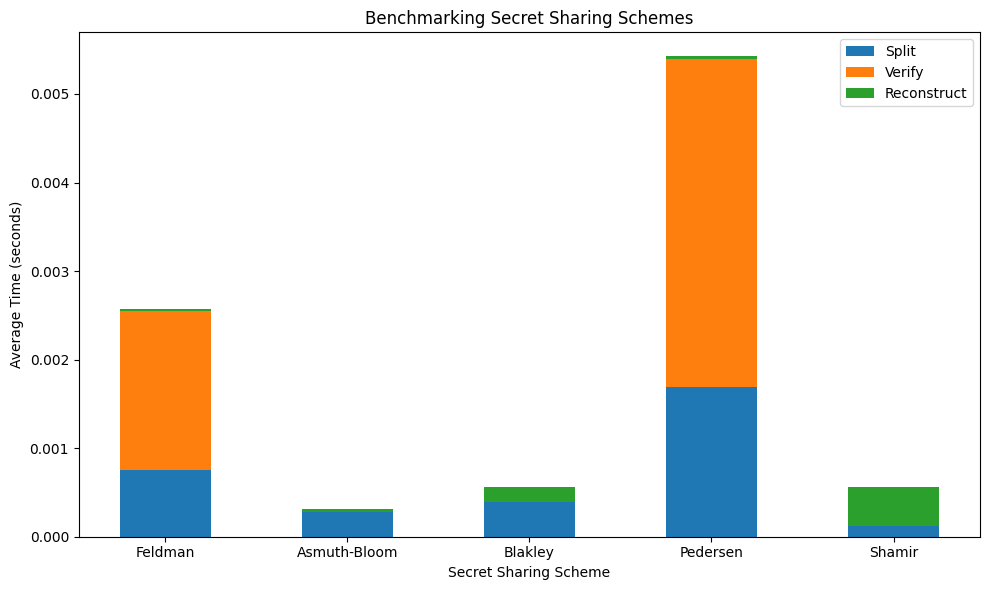

In [64]:
labels = ["Feldman", "Asmuth-Bloom", "Blakley", "Pedersen", "Shamir"]
split_data = [feldman_split_time, ab_split_time, blakley_split_time, pedersen_split_time, shamir_split_time]
verify_data = [feldman_verify_time, ab_verify_time, blakley_verify_time, pedersen_verify_time, shamir_verify_time]
reconstruct_data = [feldman_reconstruct_time, ab_reconstruct_time, blakley_reconstruct_time, pedersen_reconstruct_time, shamir_reconstruct_time]

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(labels))
bar_width = 0.5

ax.bar(x, split_data, bar_width, label="Split")
ax.bar(x, verify_data, bar_width, bottom=split_data, label="Verify")
ax.bar(x, reconstruct_data, bar_width, bottom=np.array(split_data) + np.array(verify_data), label="Reconstruct")

# Add labels, title, and ticks
ax.set_xlabel('Secret Sharing Scheme')
ax.set_ylabel('Average Time (seconds)')
ax.set_title('Benchmarking Secret Sharing Schemes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

In [65]:
def benchbysize(secret, threshold, num_shares):
    def benchmark(name, split_func, verify_func, reconstruct_func, num_iterations=1000):
        print(f"\nBenchmarking {name}...")

        # Store the times for each subsection over all iterations
        split_times = []
        verify_times = []
        reconstruct_times = []

        for _ in range(num_iterations):
            start_total = time.perf_counter()

            # Split phase
            start = time.perf_counter()
            shares, metadata = split_func()
            end = time.perf_counter()
            split_times.append(end - start)

            # Verification phase
            if verify_func is not None:
                start = time.perf_counter()
                for share in shares:
                    verify_func(share, metadata)
                end = time.perf_counter()
                verify_times.append(end - start)
            else:
                verify_times.append(0)  # No verification phase if function is None

            # Reconstruction phase
            start = time.perf_counter()
            if metadata is not None:
                reconstruct_func((shares, metadata))
            else:
                reconstruct_func(shares)
            end = time.perf_counter()
            reconstruct_times.append(end - start)

            end_total = time.perf_counter()

        # Calculate average times
        avg_split_time = np.mean(split_times)
        avg_verify_time = np.mean(verify_times)
        avg_reconstruct_time = np.mean(reconstruct_times)

        print(f"Average Split time: {avg_split_time:.6f} seconds")
        print(f"Average Verification time: {avg_verify_time:.6f} seconds")
        print(f"Average Reconstruction time: {avg_reconstruct_time:.6f} seconds")

        return avg_split_time, avg_verify_time, avg_reconstruct_time

    ### Feldman
    feldman = FeldmanVerifiableSecretSharing(threshold=threshold, num_shares=num_shares)

    def feldman_split():
        shares, commitments = feldman.split(secret)
        return shares, commitments

    def feldman_verify(share, commitments):
        x, y = share
        feldman.verify_share(x, y, commitments)

    def feldman_reconstruct(input_val):
        # Accept either a list of shares or a tuple (shares, metadata)
        if isinstance(input_val, tuple):
            shares, _ = input_val
        else:
            shares = input_val
        return feldman.reconstruct(shares[:threshold])

    ### Asmuth-Bloom
    def ab_split():
        ab = AsmuthBloom(n_holders=num_shares, min_holder=threshold, secret=secret, verbose=False)
        return ab.get_holders(), ab

    def ab_reconstruct(holders_and_ab):
        holders, ab = holders_and_ab
        # Inject holders into ab to make sure solve() uses them
        ab.holders = holders
        return ab.solve()
    ### Blakley
    blakley = BlakleySecretSharing(threshold=threshold, num_shares=num_shares)

    def blakley_split():
        shares = blakley.split(secret)
        return shares, None

    def blakley_reconstruct(shares):
        return blakley.reconstruct(shares[:threshold])
    ### Pedersen
    pedersen = PedersenSecretSharing(threshold=threshold, num_shares=num_shares)

    def pedersen_split():
        shares, commitments = pedersen.split(secret)
        return shares, commitments

    def pedersen_verify(share, commitments):
        x, s, r = share
        return pedersen.verify_share(x, s, r, commitments)

    def pedersen_reconstruct(shares_and_commitments):
        shares, _ = shares_and_commitments
        return pedersen.reconstruct([(x, s) for x, s, r in shares[:threshold]])
    ### Shamir
    sss = ShamirSecretSharing(threshold=threshold, num_shares=num_shares, bit_length=256)

    def shamir_split():
        shares = sss.split(secret)
        # Add a dummy third element 'r' to simulate Pedersen's (x, s, r)
        shares_with_r = [(x, y, 0) for (x, y) in shares]
        return shares_with_r, None

    def shamir_reconstruct(shares_with_r):
        # Simulate Pedersen's unpacking overhead
        sliced = shares_with_r[:threshold]
        just_shares = [(x, y) for (x, y, r) in sliced]
        return sss.reconstruct(just_shares)
    feldman_split_time, feldman_verify_time, feldman_reconstruct_time = benchmark("Feldman", feldman_split, feldman_verify, feldman_reconstruct)
    ab_split_time, ab_verify_time, ab_reconstruct_time = benchmark("Asmuth-Bloom", ab_split, None, ab_reconstruct)
    blakley_split_time, blakley_verify_time, blakley_reconstruct_time = benchmark("Blakley", blakley_split, None, blakley_reconstruct)
    pedersen_split_time, pedersen_verify_time, pedersen_reconstruct_time = benchmark("Pedersen", pedersen_split, pedersen_verify, pedersen_reconstruct)
    shamir_split_time, shamir_verify_time, shamir_reconstruct_time = benchmark("Shamir", shamir_split, None, shamir_reconstruct)
    labels = ["Feldman", "Asmuth-Bloom", "Blakley", "Pedersen", "Shamir"]
    split_data = [feldman_split_time, ab_split_time, blakley_split_time, pedersen_split_time, shamir_split_time]
    verify_data = [feldman_verify_time, ab_verify_time, blakley_verify_time, pedersen_verify_time, shamir_verify_time]
    reconstruct_data = [feldman_reconstruct_time, ab_reconstruct_time, blakley_reconstruct_time, pedersen_reconstruct_time, shamir_reconstruct_time]

    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(labels))
    bar_width = 0.5

    # Use a colormap (colorblind-friendly, soft colors)
    cmap = plt.get_cmap('Set2')
    split_color = '#4dbd6b'
    verify_color = '#8f60cc'  # orangish
    reconstruct_color = '#f24b7d'  # purplish

    # Plot with explicit colors for each layer
    ax.bar(x, split_data, bar_width, label="Split", color=split_color)
    ax.bar(x, verify_data, bar_width, bottom=split_data, label="Verify", color=verify_color)
    ax.bar(x, reconstruct_data, bar_width, bottom=np.array(split_data) + np.array(verify_data), label="Reconstruct", color=reconstruct_color)

    # Labels and aesthetics
    ax.set_xlabel('Secret Sharing Scheme')
    ax.set_ylabel('Average Time (seconds)')
    ax.set_title(f'Benchmarking Secret Sharing Schemes\nfor {num_shares} shares, threshold = {threshold}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha='right')
    ax.legend()

    # Add a light grid
    ax.grid(axis='y', linestyle='--')

    plt.tight_layout()
    plt.show()

In [66]:
benchbysize(123456789, 5, 10)
benchbysize(123456789, 5, 100)
benchbysize(123456789, 5, 1000)
benchbysize(123456789, 10, 10)
benchbysize(123456789, 10, 100)
benchbysize(123456789, 50, 100)

KeyboardInterrupt: 